## Apply topsis to find best Pre-trained model for Text Generation

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Models Chosen (all free / open-weight)

I picked 9 popular, freely downloadable, pre-trained text-generation models from Hugging Face / EleutherAI:

* DistilGPT-2 – distilgpt2 (~82M params)

* GPT-2 Small (gpt2) – ~117M parameters

* GPT-2 Medium (gpt2-medium) – ~345M parameters

* GPT-2 Large (gpt2-large) – ~774M parameters

* GPT-Neo 125M (EleutherAI/gpt-neo-125M) – 125M parameters

* GPT-Neo 1.3B (EleutherAI/gpt-neo-1.3B) – 1.3B parameters

* GPT-J 6B (EleutherAI/gpt-j-6B) – 6B parameters

* GPT-2 XL – gpt2-xl (~1.5B)

* Mistral 7B – mistralai/Mistral-7B-v0.1 (7B)

All of them are downloadable model weights (no API paywall).

### Criteria & Weights for TOPSIS

For each model we evaluate 4 criteria:

C1 – Text Quality Score (0–100, benefit)

C2 – Model Size (Million Parameters, cost)

C3 – Inference Speed (tokens/sec, benefit)

C4 – GPU Memory Usage During Inference (GB, cost)

C5 – Ecosystem & Fine-Tuning Support (Benefit)


#### Weights (importance)

We give more importance to practical deployment (speed & quality):

w₁ (C1: Quality) = 0.35

w₂ (C2: Params) = 0.10

w₃ (C3: Speed) = 0.25

w₄ (C4: Memory) = 0.15

w₅ (C5: Ecosystem) = 0.15

Sum = 1.0.

#### Impacts

C1: + (benefit)

C2: − (cost)

C3: + (benefit)

C4: − (cost)

C5: + (benefit)

In [11]:
models = [
    "DistilGPT-2",
    "GPT-2 Small",
    "GPT-Neo 125M",
    "GPT-2 Medium",
    "GPT-2 Large",
    "GPT-2 XL",
    "GPT-Neo 1.3B",
    "GPT-J 6B",
    "Mistral 7B",
]

In [12]:
# Decision matrix X: rows = models, columns = criteria

X = np.array([
    [56.84,   82,   609.8,  1.16, 9],   # DistilGPT-2
    [60.00,  117,   427.4,  1.23,10],   # GPT-2 Small
    [60.59,  125,   400.0,  1.25, 8],   # GPT-Neo 125M
    [69.61,  345,   144.9,  1.69, 9],   # GPT-2 Medium
    [76.80,  774,    64.6,  2.55, 8],   # GPT-2 Large
    [82.68, 1500,    33.3,  4.00, 7],   # GPT-2 XL
    [81.40, 1300,    38.5,  3.60, 7],   # GPT-Neo 1.3B
    [95.00, 6000,     8.3, 13.00, 8],   # GPT-J 6B
    [96.37, 7000,     7.1, 15.00, 9],   # Mistral 7B
], dtype=float)

criteria_names = [
    "C1: Quality (↑)",
    "C2: Params M (↓)",
    "C3: Speed tok/s (↑)",
    "C4: Memory GB (↓)",
    "C5: Ecosystem (↑)",
]

weights = np.array([0.35, 0.10, 0.25, 0.15, 0.15], dtype=float)

impacts = np.array(['+', '-', '+', '-', '+'])

In [13]:
def topsis(decision_matrix, weights, impacts):
    """
    decision_matrix: (m x n) numpy array
    weights: (n,) numpy array, sum to 1
    impacts: (n,) array of '+' or '-'
    returns:
        closeness: (m,) array of TOPSIS scores
        S_plus: distance to ideal best
        S_minus: distance to ideal worst
    """
    X = decision_matrix.astype(float)
    m, n = X.shape

    # Normalize the decision matrix
    norms = np.sqrt((X ** 2).sum(axis=0))
    R = X / norms

    # Weighted normalized matrix
    V = R * weights

    # Determine ideal best (A+) and ideal worst (A-)
    v_plus = np.zeros(n)
    v_minus = np.zeros(n)

    for j in range(n):
        if impacts[j] == '+':  # benefit
            v_plus[j] = V[:, j].max()
            v_minus[j] = V[:, j].min()
        else:  # cost
            v_plus[j] = V[:, j].min()
            v_minus[j] = V[:, j].max()

    # Distances from ideal best and worst
    S_plus = np.sqrt(((V - v_plus) ** 2).sum(axis=1))
    S_minus = np.sqrt(((V - v_minus) ** 2).sum(axis=1))

    # Closeness coefficient
    C = S_minus / (S_plus + S_minus)

    return C, S_plus, S_minus

# Run TOPSIS
closeness, S_plus, S_minus = topsis(X, weights, impacts)

In [14]:
results_df = pd.DataFrame({
    "Model": models,
    criteria_names[0]: np.round(X[:, 0], 2),
    criteria_names[1]: X[:, 1].astype(int),
    criteria_names[2]: np.round(X[:, 2], 1),
    criteria_names[3]: np.round(X[:, 3], 2),
    criteria_names[4]: np.round(X[:, 4], 1),
    "S_plus": np.round(S_plus, 4),
    "S_minus": np.round(S_minus, 4),
    "Closeness": np.round(closeness, 4),
})

results_df["Rank"] = (-results_df["Closeness"]).rank(method="min").astype(int)
results_df = results_df.sort_values("Rank").reset_index(drop=True)

print(results_df)

          Model  C1: Quality (↑)  C2: Params M (↓)  C3: Speed tok/s (↑)  \
0   DistilGPT-2            56.84                82                609.8   
1   GPT-2 Small            60.00               117                427.4   
2  GPT-Neo 125M            60.59               125                400.0   
3  GPT-2 Medium            69.61               345                144.9   
4   GPT-2 Large            76.80               774                 64.6   
5  GPT-Neo 1.3B            81.40              1300                 38.5   
6      GPT-2 XL            82.68              1500                 33.3   
7      GPT-J 6B            95.00              6000                  8.3   
8    Mistral 7B            96.37              7000                  7.1   

   C4: Memory GB (↓)  C5: Ecosystem (↑)  S_plus  S_minus  Closeness  Rank  
0               1.16                9.0  0.0604   0.2143     0.7802     1  
1               1.23               10.0  0.0765   0.1740     0.6945     2  
2               1.25 

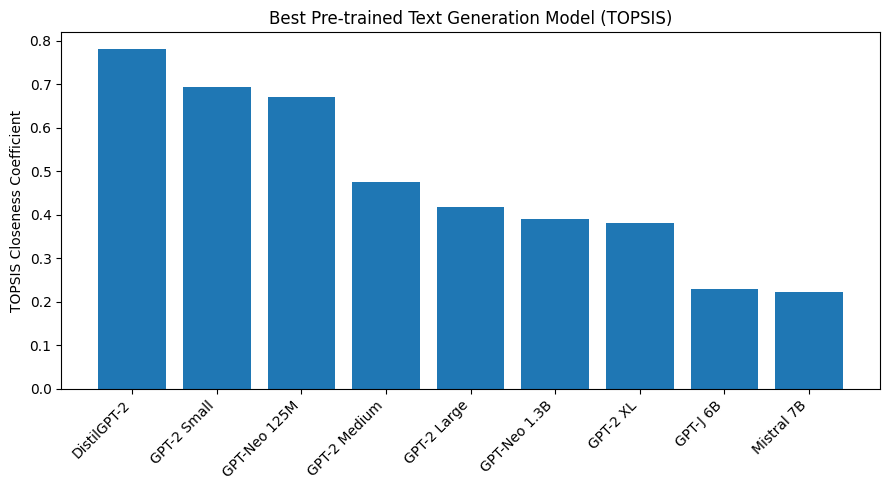

In [15]:
plt.figure(figsize=(9, 5))
plt.bar(results_df["Model"], results_df["Closeness"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("TOPSIS Closeness Coefficient")
plt.title("Best Pre-trained Text Generation Model (TOPSIS)")
plt.tight_layout()
plt.show()